In [1]:
!pip install nflows

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 45 kB 1.2 MB/s eta 0:00:011
     |████████████████████████████████| 755.5 MB 57 kB/s s eta 0:00:012    |████████████                    | 285.8 MB 25.2 MB/s eta 0:00:19     |██████████████████████▌         | 531.8 MB 9.0 MB/s eta 0:00:25     |███████████████████████████████ | 732.1 MB 16.5 MB/s eta 0:00:02
     |████████████████████████████████| 196.0 MB 3.7 MB/s eta 0:00:011
     |████████████████████████████████| 1.6 MB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 56.5 MB 32.5 MB/s eta 0:00:01
     |████████████████████████████████| 5.7 MB 14.2 MB/s eta 0:00:01
     |████████████████████████████████| 23.7 MB 25.6 MB/s eta 0:00:01
     |████████████████████████████████| 14.1 MB 41.6 MB/s eta 0:00:01
     |████████████████████████████████| 167.9 MB 20.4 MB/s eta 0:00:01
     |████████████████████████████████| 121.6 MB 23.4 MB/s eta 0:00:01
     |███████

In [1]:
from scipy.stats import chi2, expon, weibull_min
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from copy import deepcopy
import os

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import nflows
from nflows import flows, transforms
from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.distributions.base import Distribution
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet
from nflows.utils import torchutils

np.random.seed(100)
print(torch.cuda.is_available())

False


In [3]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available")
    # Get current CUDA device index
    current_device = torch.cuda.current_device()
    print("Current CUDA Device index:", current_device)
    # Get name of the current CUDA device
    print("Current CUDA Device:", torch.cuda.get_device_name(current_device))
    device = torch.device("cuda")
else:
    print("CUDA is not available, using CPU instead.")
    device = torch.device("cpu")

print("Using device:", device)

CUDA is not available, using CPU instead.
Using device: cpu


In [4]:
class MyDataset(Dataset):
    def __init__(
        self,
        dataframe,
        context_variables,
        target_variables,
        device=None,
        rows=None,
    ):
        self.context_variables = context_variables
        self.target_variables = target_variables
        self.all_variables = context_variables + target_variables
        data = dataframe
        if rows is not None:
            data = data.iloc[:rows]
        self.target = data[target_variables].values
        self.context = data[context_variables].values
        self.weights = data[['weight']].values
        if device is not None:
            self.target = torch.tensor(self.target, dtype=torch.float32).to(device)
            self.context = torch.tensor(self.context, dtype=torch.float32).to(device)
            self.weights = torch.tensor(self.weights, dtype=torch.float32).to(device)

    def __len__(self):
        assert len(self.context) == len(self.target)
        return len(self.target)

    def __getitem__(self, idx):
        return self.context[idx], self.target[idx], self.weights[idx]

In [5]:
input_dir = "./flowsSample"
df = pd.read_parquet(os.path.join(input_dir, "train.parquet"))
df_target = pd.read_parquet(os.path.join(input_dir, "train_target.parquet"))
df_test = pd.read_parquet(os.path.join(input_dir, "test.parquet"))
df_target_test = pd.read_parquet(os.path.join(input_dir, "test_target.parquet"))

context_vars = ['a', 'b']
input_vars = ['x', 'y']
rows = 100000
rows_test = 100000
batch_size = 1000
print(len(df), len(df_test))
mc_dataset_train = MyDataset(df, context_vars, input_vars, device=device, rows=rows)
mc_loader_train = DataLoader(mc_dataset_train, batch_size=batch_size)
data_dataset_train = MyDataset(df_target, context_vars, input_vars, device=device, rows=rows)
data_loader_train = DataLoader(data_dataset_train, batch_size=batch_size)
mc_dataset_test = MyDataset(df_test, context_vars, input_vars, device=device, rows=rows_test)
mc_loader_test = DataLoader(mc_dataset_test, batch_size=batch_size)
data_dataset_test = MyDataset(df_target_test, context_vars, input_vars, device=device, rows=rows_test)
data_loader_test = DataLoader(data_dataset_test, batch_size=batch_size)

1400000 600000


In [6]:
mc_dataset_train.context.get_device()

-1

In [20]:
ninput = len(input_vars)
ncontext = len(context_vars)

epochs = 20
plot_every = 5

class DiagonalGaussian(Distribution):
    """A diagonal multivariate Normal with trainable parameters."""

    def __init__(self, shape, mean, std):
        """Constructor.

        Args:
            shape: list, tuple or torch.Size, the shape of the input variables.
            context_encoder: callable or None, encodes the context to the distribution parameters.
                If None, defaults to the identity function.
        """
        super().__init__()
        self._shape = torch.Size(shape)
        self.mean_ = nn.Parameter(mean * torch.ones(shape).reshape(1, -1))
        self.log_std_ = nn.Parameter(np.log(std) * torch.ones(shape).reshape(1, -1))
        self.register_buffer("_log_z",
                             torch.tensor(0.5 * np.prod(shape) * np.log(2 * np.pi),
                                          dtype=torch.float32),
                             persistent=False)

    def _log_prob(self, inputs, context):
        if inputs.shape[1:] != self._shape:
            raise ValueError(
                "Expected input of shape {}, got {}".format(
                    self._shape, inputs.shape[1:]
                )
            )

        # Compute parameters.
        means = self.mean_
        log_stds = self.log_std_

        # Compute log prob.
        norm_inputs = (inputs - means) * torch.exp(-log_stds)
        log_prob = -0.5 * torchutils.sum_except_batch(
            norm_inputs ** 2, num_batch_dims=1
        )
        log_prob -= torchutils.sum_except_batch(log_stds, num_batch_dims=1)
        log_prob -= self._log_z
        return log_prob

    def _sample(self, num_samples, context):
        means = self.mean_
        log_stds = self.log_std_
        stds = torch.exp(log_stds)
        means = torchutils.repeat_rows(means, num_samples)
        stds = torchutils.repeat_rows(stds, num_samples)

        # Generate samples.
        context_size = context.shape[0]
        noise = torch.randn(context_size * num_samples, *
                            self._shape, device=means.device)
        samples = means + stds * noise
        return torchutils.split_leading_dim(samples, [context_size, num_samples])

    def _mean(self, context):
        return self.mean

def spline_inn(
    inp_dim,
    nodes=128,
    num_blocks=2,
    num_stack=3,
    tail_bound=3.5,
    tails="linear",
    activation=F.relu,
    lu=0,
    num_bins=10,
    context_features=None,
    dropout_probability=0.0,
    flow_for_flow=False,
):
    transform_list = []
    for i in range(num_stack):
        transform_list += [
            transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                inp_dim,
                nodes,
                num_blocks=num_blocks,
                tail_bound=tail_bound,
                num_bins=num_bins,
                tails=tails,
                activation=activation,
                dropout_probability=dropout_probability,
                context_features=context_features,
            )
        ]
        if lu:
            transform_list += [transforms.LULinear(inp_dim)]
        else:
            transform_list += [transforms.ReversePermutation(inp_dim)]

    if not (flow_for_flow and (num_stack % 2 == 0)):
        # If the above conditions are satisfied then you want to permute back to the original ordering such that the
        # output features line up with their original ordering.
        transform_list = transform_list[:-1]

    return transforms.CompositeTransform(transform_list)

def get_conditional_base_flow(
    input_dim,
    context_dim,
    nstack,
    nnodes,
    nblocks,
    tail_bound,
    nbins,
    activation,
    dropout_probability,
):
    flow = Flow(
        spline_inn(
            input_dim,
            nodes=nnodes,
            num_blocks=nblocks,
            num_stack=nstack,
            tail_bound=tail_bound,
            activation=getattr(F, activation),
            dropout_probability=dropout_probability,
            num_bins=nbins,
            context_features=context_dim,
        ),
        #ConditionalDiagonalNormal(
        #    shape=[input_dim], context_encoder=nn.Linear(context_dim, 2 * input_dim)
        #),
        DiagonalGaussian(shape=[input_dim], mean=0., std=0.25),
    )

    return flow

def make_base_flow_and_train(loader, test_loader, df_test):
    flow = get_conditional_base_flow(
        input_dim=ninput,
        context_dim=ncontext,
        nstack=2,
        nnodes=8,
        nblocks=4,
        tail_bound=1.0,
        nbins=8,
        activation="relu",
        dropout_probability=0.1,
    )
    flow = flow.to(device)
    optimizer = optim.Adam(flow.parameters())

    train_history, test_history = [], []
    for epoch in range(epochs + 1):
        print(epoch)
        train_losses, test_losses = [], []

        # train
        for ab, xy, weights in loader:
            loss = -flow.log_prob(inputs=xy, context=ab) * weights
            loss = loss.mean()
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_train_loss = np.mean(train_losses)
        train_history.append(epoch_train_loss)

        # test
        print('testing')
        for ab, xy, weights in test_loader:
            with torch.no_grad():
                loss = -flow.log_prob(inputs=xy, context=ab) * weights
                loss = loss.mean()
                test_losses.append(loss.item())
        
        epoch_test_loss = np.mean(test_losses)
        test_history.append(epoch_test_loss)
        if epoch % plot_every == 0:
            print("plotting")
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
            # Example data and function calls (ensure these are defined in your code)
            a, b, x, y = df_test['a'].values, df_test['b'].values, df_test['x'].values, df_test['y'].values
            xy_sample = flow.sample(1, context=torch.tensor(df_test[['a', 'b']].values, dtype=torch.float32).to(device)).reshape(-1, 2)
            x_sample = xy_sample[:, 0].detach().cpu().numpy()
            y_sample = xy_sample[:, 1].detach().cpu().numpy()

            # Common limits for histograms
            x_min, x_max = min(x.min(), x_sample.min()), max(x.max(), x_sample.max())
            y_min, y_max = min(y.min(), y_sample.min()), max(y.max(), y_sample.max())

            # Plotting histograms for x
            ax1.hist(x, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='sample')
            ax1.hist(x_sample, bins=100, range=(x_min, x_max), density=True, alpha=0.5, color='red', label='flow')
            ax1.legend(markerscale=50, loc="best", fontsize=24)
            ax1.tick_params(width=2, grid_alpha=0.5)
            ax1.set_xlabel('X Values', fontsize=24)
            ax1.text(0.13, 1.02, r'$\mathbf{FUW}$ $\mathit{Private}$', transform=ax1.transAxes, fontsize=12, ha='center', bbox=dict(facecolor='none', edgecolor='none', boxstyle='square'))

            # Plotting histograms for y
            ax2.hist(y, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='sample')
            ax2.hist(y_sample, bins=100, range=(y_min, y_max), density=True, alpha=0.5, color='red', label='flow')
            ax2.legend(markerscale=50, loc="best", fontsize=24)
            ax2.tick_params(width=2, grid_alpha=0.5)
            ax2.set_xlabel('Y Values', fontsize=24)
            ax2.text(0.13, 1.02, r'$\mathbf{FUW}$ $\mathit{Private}$', transform=ax2.transAxes, fontsize=12, ha='center', bbox=dict(facecolor='none', edgecolor='none', boxstyle='square'))

            # Plotting loss
            ax3.plot(train_history, label='train')
            ax3.plot(test_history, label='test')
            ax3.legend(markerscale=50, loc="best", fontsize=24)
            ax3.tick_params(width=2, grid_alpha=0.5)
            ax3.text(0.13, 1.02, r'$\mathbf{FUW}$ $\mathit{Private}$', transform=ax3.transAxes, fontsize=12, ha='center', bbox=dict(facecolor='none', edgecolor='none', boxstyle='square'))

            # Adjust layout to not overlap content and save figures
            plt.tight_layout()
            plt.savefig(f'For_epoch_{epoch}.pdf', bbox_inches='tight')
            plt.savefig(f'For_epoch_{epoch}.png', dpi=300, bbox_inches='tight')
            plt.show()    
        return flow
 
"""
        if epoch % plot_every == 0:
            print("plotting")
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
            a, b, x, y = df_test['a'].values, df_test['b'].values, df_test['x'].values, df_test['y'].values
            xy_sample = flow.sample(1, context=torch.tensor(df_test[['a', 'b']].values, dtype=torch.float32).to(device)).reshape(-1, ninput)
            x_sample = xy_sample[:, 0].detach().cpu().numpy()
            y_sample = xy_sample[:, 1].detach().cpu().numpy()
            x_min = min(x.min(), x_sample.min())
            x_max = max(x.max(), x_sample.max())
            ax1.hist(x, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='sample');
            ax1.hist(x_sample, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='flow');
            y_min = min(y.min(), y_sample.min())
            y_max = max(y.max(), y_sample.max())
            ax1.legend()
            ax2.hist(y, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='sample');
            ax2.hist(y_sample, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='flow');
            ax2.legend()
            # plot loss
            ax3.plot(train_history, label='train')
            ax3.plot(test_history, label='test')
            ax3.legend()
            plt.show()
"""    
 

'\n        if epoch % plot_every == 0:\n            print("plotting")\n            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))\n            a, b, x, y = df_test[\'a\'].values, df_test[\'b\'].values, df_test[\'x\'].values, df_test[\'y\'].values\n            xy_sample = flow.sample(1, context=torch.tensor(df_test[[\'a\', \'b\']].values, dtype=torch.float32).to(device)).reshape(-1, ninput)\n            x_sample = xy_sample[:, 0].detach().cpu().numpy()\n            y_sample = xy_sample[:, 1].detach().cpu().numpy()\n            x_min = min(x.min(), x_sample.min())\n            x_max = max(x.max(), x_sample.max())\n            ax1.hist(x, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label=\'sample\');\n            ax1.hist(x_sample, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label=\'flow\');\n            y_min = min(y.min(), y_sample.min())\n            y_max = max(y.max(), y_sample.max())\n            ax1.legend()\n            ax2.hist(y, bins=100, r

0
testing
plotting


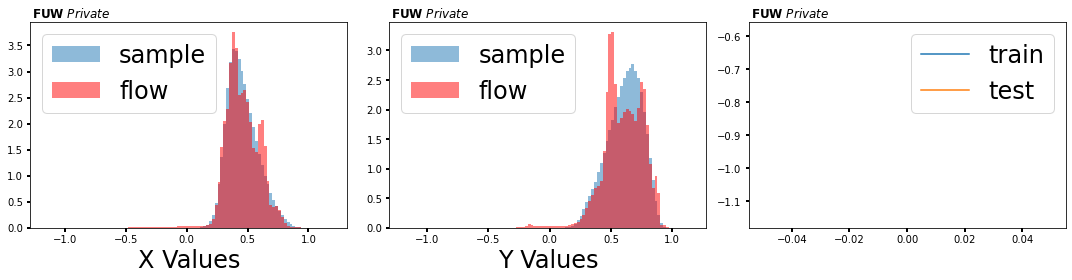

In [21]:
flow_mc = make_base_flow_and_train(mc_loader_train, mc_loader_test, df_test)